![ADME](https://storage.googleapis.com/polaris-public/icons/icons8-whale-96-ADME.png) 

# ADME data curation


## Background

The goal of accessing ADME properties is to understand how a potential drug candidate interacts with the human body, including absorption, distribution, metabolism, and excretion. This knowledge is crucial for evaluating efficacy, safety, and clinical potential, guiding drug development for optimal therapeutic outcomes. Fang et al. 2023 has disclosed DMPK datasets collected over 20 months across six ADME in vitro endpoints, which are human and rat liver microsomal stability, MDR1-MDCK efflux ratio, solubility, and human and rat plasma protein binding. The dataset contains 885 to 3087 measures for the corresponding endpoints. The compounds show the chemical diversity across all ranges of the endpoints which are microsomal stability, plasma protein binding, permeability, and solubility.

## Description of readout
- Microsomal stability (human and rat):  `LOG HLM_CLint (mL/min/kg)`, `LOG RLM_CLint (mL/min/kg)`
- Plasma protein binding (human and rat): `LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)`, `LOG PLASMA PROTEIN BINDING (RAT) (% unbound)`
- Permeability: `LOG MDR1-MDCK ER (B-A/A-B)`
- Solubility: `LOG SOLUBILITY PH 6.8 (ug/mL)`


## Data resource
**Reference**: [Prospective Validation of Machine Learning Algorithms for Absorption, Distribution, Metabolism, and Excretion Prediction: An Industrial Perspective]( https://doi.org/10.1021/acs.jcim.3c00160)

**Github**: https://github.com/molecularinformatics/Computational-ADME

**Raw data**: https://github.com/molecularinformatics/Computational-ADME/blob/main/ADME_public_set_3521.csv 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pathlib
import datetime
import re
import warnings

os.chdir(pathlib.Path("__file__").absolute().parents[1])
import datamol as dm
import pandas as pd
from polaris import curation
from polaris.curation._chemistry_curator import SMILES_COL, UNIQUE_ID

warnings.filterwarnings("ignore")

from utils import molecule_checker

In [2]:
# load data
data = dm.read_csv("gs://polaris-public/data/raw/fang2023_ADME_public_set_3521.csv")

In [3]:
# Specify names and extract the test set from their dataset
endpoints = {
    "HLM": "HLM_CLint",
    "RLM": "RLM_CLint",
    "hPPB": "HPPB",
    "rPPB": "RPPB",
    "MDR1_ER": "MDR1-MDCK_ER",
    "Sol": "SOLUBILITY",
}

_endpoint = list(endpoints.keys())
INDIR = "gs://polaris-public/Data/ADME/fang2023/MPNN"

In [4]:
split_key = "fang2023split"
paper_splits = {}
for endpoint in _endpoint:
    testset = dm.read_csv(f"{INDIR}/ADME_{endpoint}_test.csv")
    paper_splits[endpoints[endpoint]] = (
        data.loc[~data.SMILES.isin(testset.smiles)].index.values,
        data.loc[data.SMILES.isin(testset.smiles)].index.values,
    )

In [5]:
# Define data column names
endpoints = {
    "HLM": "LOG HLM_CLint (mL/min/kg)",
    "RLM": "LOG RLM_CLint (mL/min/kg)",
    "hPPB": "LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)",
    "rPPB": "LOG PLASMA PROTEIN BINDING (RAT) (% unbound)",
    "MDR1_ER": "LOG MDR1-MDCK ER (B-A/A-B)",
    "Sol": "LOG SOLUBILITY PH 6.8 (ug/mL)",
}
data_cols = list(endpoints.values())
mol_col = "SMILES"

In [6]:
data.describe()[data_cols]

,LOG HLM_CLint (mL/min/kg),LOG RLM_CLint (mL/min/kg),LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound),LOG PLASMA PROTEIN BINDING (RAT) (% unbound),LOG MDR1-MDCK ER (B-A/A-B),LOG SOLUBILITY PH 6.8 (ug/mL)
count,3087.000000,3054.000000,194.000000,168.000000,2642.000000,2173.000000
mean,1.320019,2.256207,0.765722,0.764177,0.397829,1.259943
std,0.623952,0.750422,0.847902,0.798988,0.688465,0.683416
min,0.675687,1.027920,-1.593460,-1.638272,-1.162425,-1.000000
25%,0.675687,1.688291,0.168067,0.226564,-0.162356,1.153510
50%,1.205313,2.311068,0.867555,0.776427,0.153291,1.542825
75%,1.803115,2.835274,1.501953,1.375962,0.905013,1.687351
max,3.372714,3.969622,2.000000,2.000000,2.725057,2.179264


### Perform data curation with `polaris.curation` module

In [7]:
# preliminary curation for data inspection
curator = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    mask_stereo_undefined_mols=False,
    keep_all_rows = True
)
df_full = curator()

2023-11-08 12:04:37.780 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 3 outliers for data column LOG HLM_CLint (mL/min/kg) using zscore. Please revise the data and consider remove the outliers. 
2023-11-08 12:04:37.784 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 1 outliers for data column LOG PLASMA PROTEIN BINDING (RAT) (% unbound) using zscore. Please revise the data and consider remove the outliers. 
2023-11-08 12:04:37.785 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 1 outliers for data column LOG MDR1-MDCK ER (B-A/A-B) using zscore. Please revise the data and consider remove the outliers. 
2023-11-08 12:04:37.787 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 20 outliers for data column LOG SOLUBILITY PH 6.8 (ug/mL) using zscore. Please revise the data and consider remove the outliers. 


## Check the outliers

The curation raised warning for potential outliers from several endpoints. The outlier labels are added in the curated output.  It's important to revise those data points and verify whether they are real outliers and should be removed from the dataset. 

We can also use other outlier detection methods by passing parameters to `outlier_params`. Please see more details in `polaris.curation.utils.outlier_detection`. 

[<Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x400 with 2 Axes>]

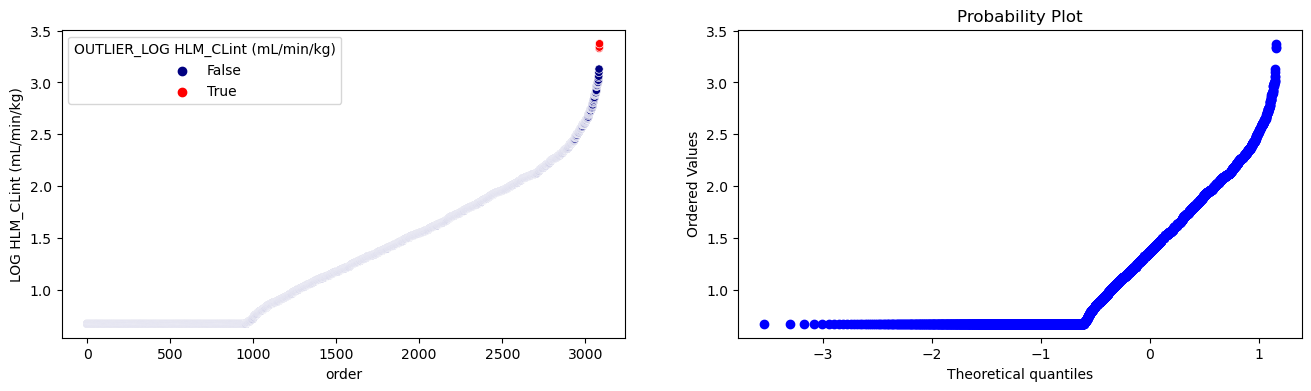

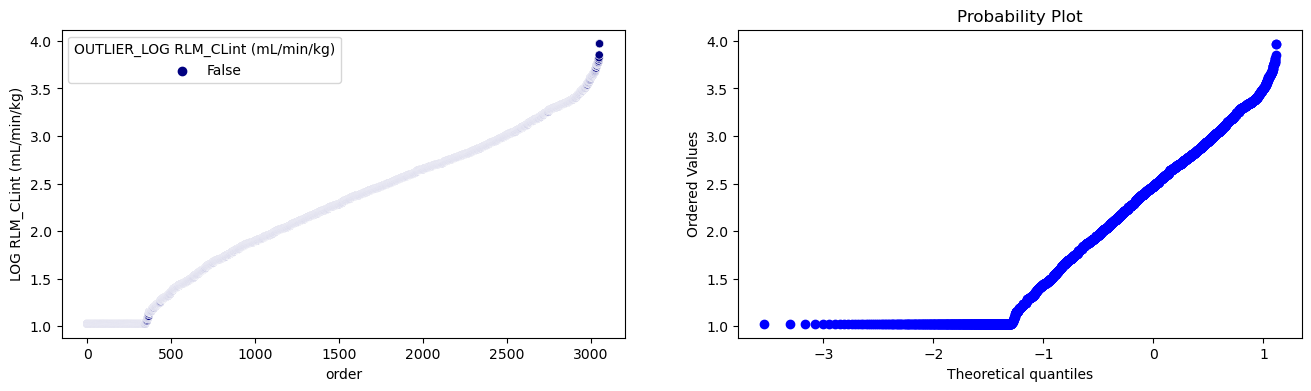

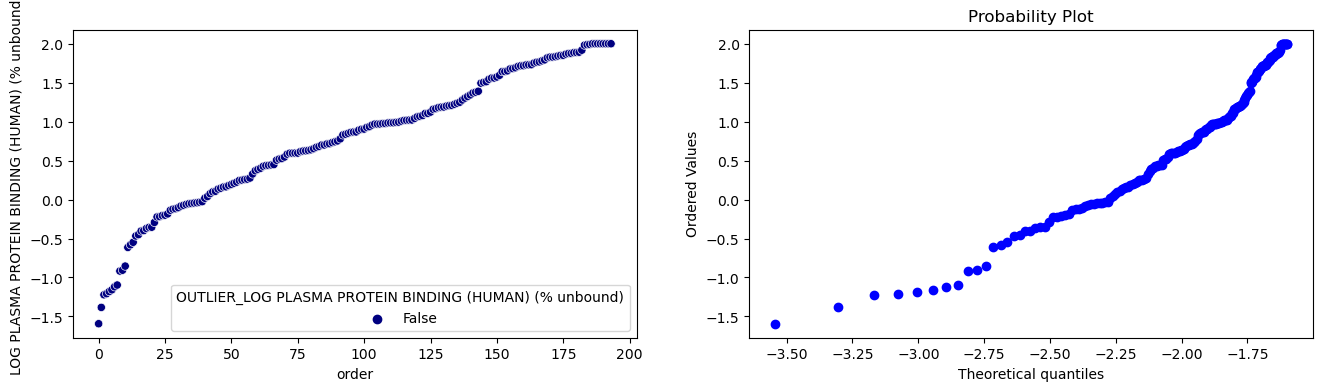

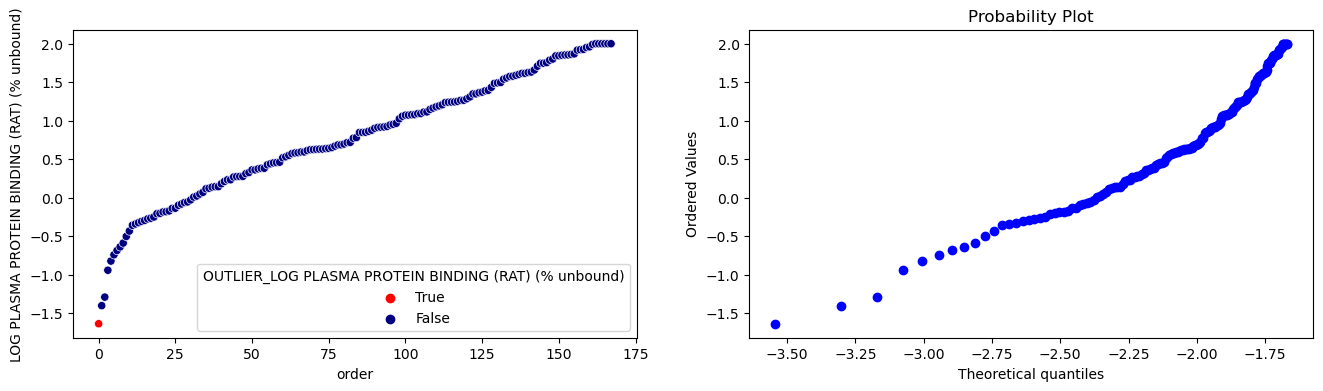

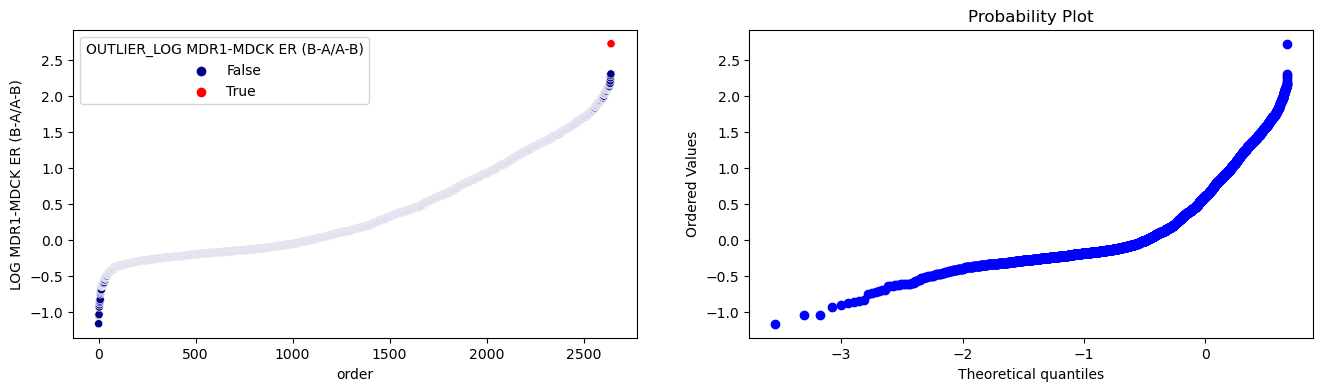

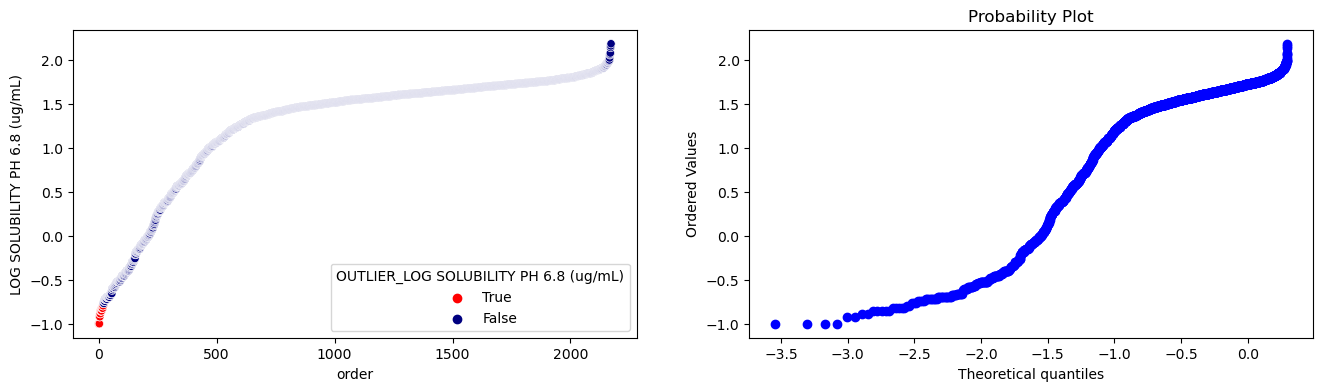

In [8]:
from polaris.curation.viz_utils import visualize_distribution

visualize_distribution(dataset=df_full, data_cols=data_cols)

The flagged outliers are likely false outliers as they are located on the terminals of the data distributions. 

### Check the activity shift between the stereo isomers

In [9]:
df_full[[col for col in df_full.columns if "stereo_cliff" in col]].sum()

LOG HLM_CLint (mL/min/kg)_stereo_cliff                         0
LOG RLM_CLint (mL/min/kg)_stereo_cliff                         0
LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)_stereo_cliff    0
LOG PLASMA PROTEIN BINDING (RAT) (% unbound)_stereo_cliff      0
LOG MDR1-MDCK ER (B-A/A-B)_stereo_cliff                        0
LOG SOLUBILITY PH 6.8 (ug/mL)_stereo_cliff                     0
dtype: object

### Check the molecules with undefined stereocenters

The stereo center of the above molecules are unspecified.  The overall % inhibition is in the low to medium range, except for kinase LOK and two EGFR mutants. However, there are no activity shifts between the stereo isomers have been detected in this dataset. Therefore, we keep the above molecules in the dataset.

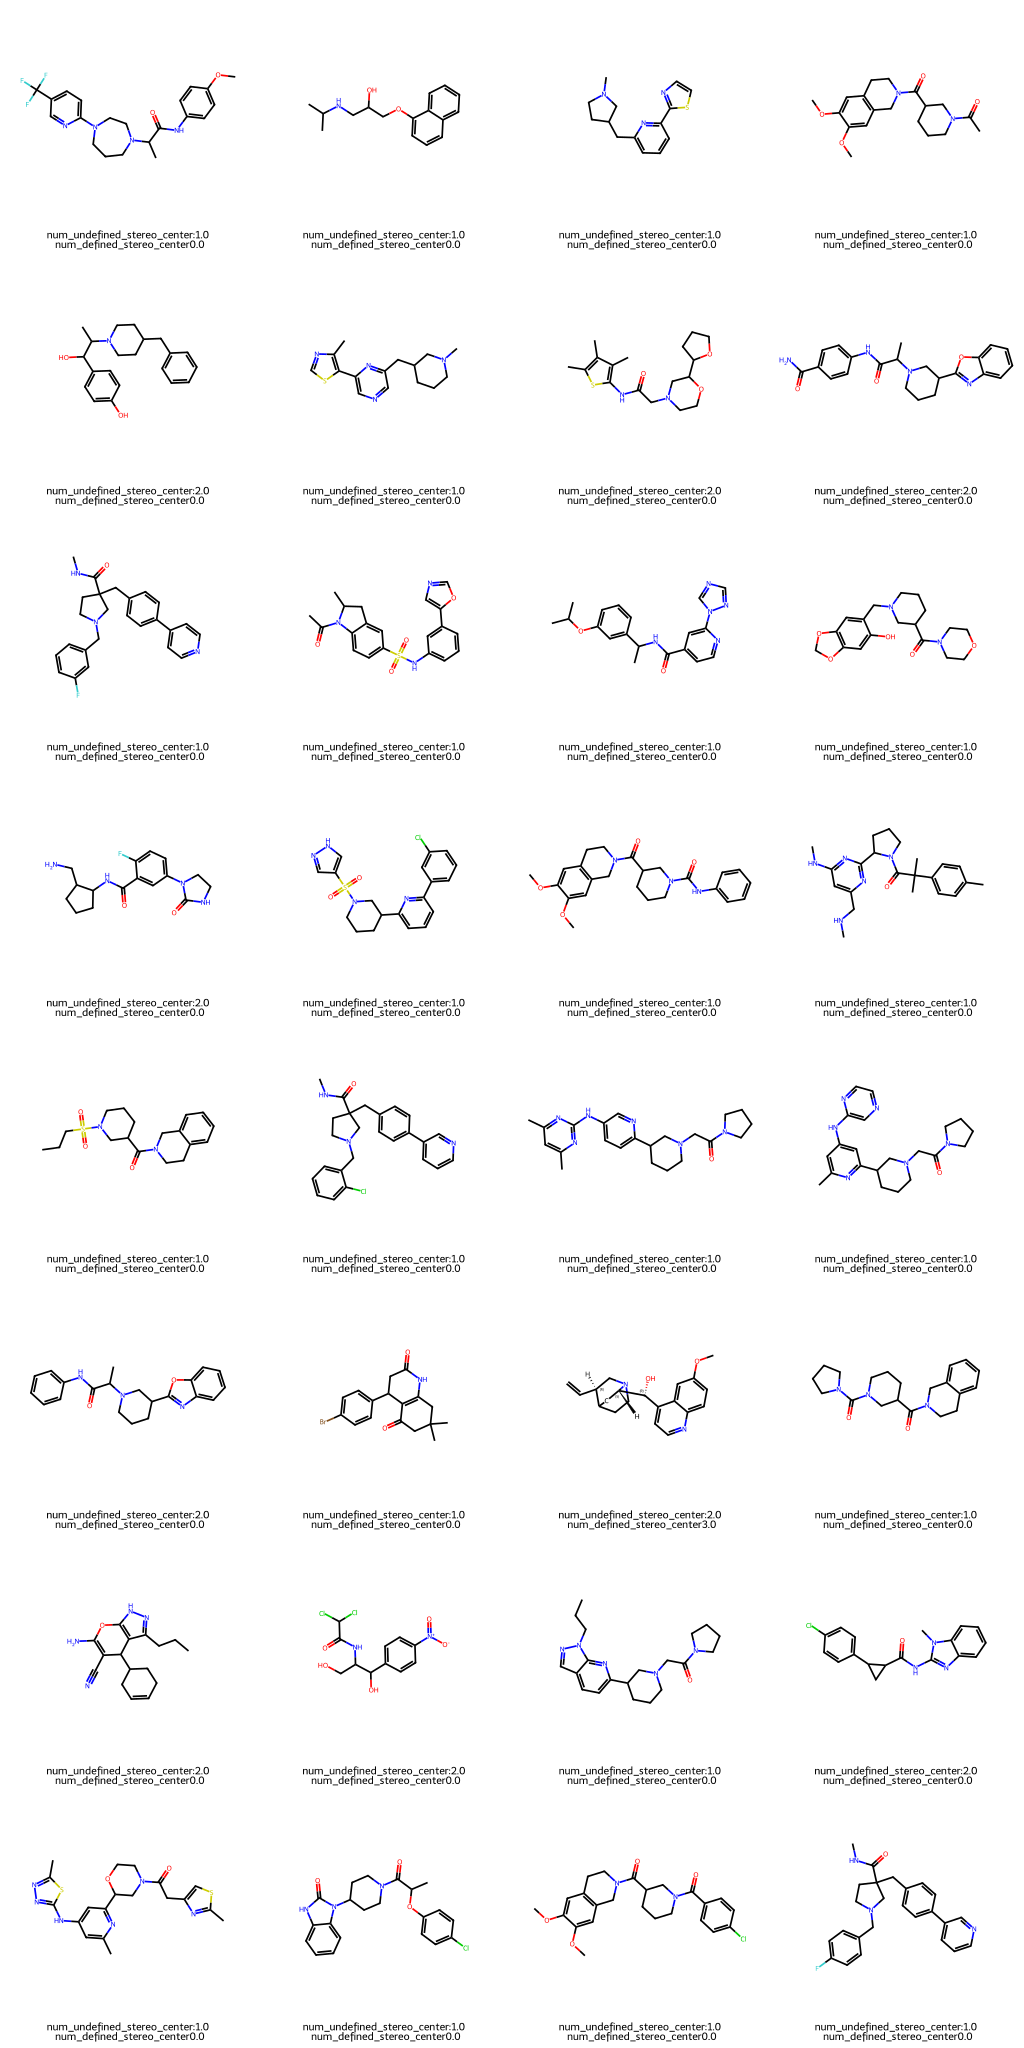

In [10]:
from polaris.curation.viz_utils import check_undefined_stereocenters

df_full["mol"] = df_full[mol_col].apply(dm.to_mol)
fig, undefined_df = check_undefined_stereocenters(dataset=df_full)
fig

The stereo center of the above molecules are unspecified. However, there are no activity shifts between the stereo isomers have been detected in this dataset. Therefore, we keep the above molecules in the dataset for now.

### Check the compounds with undesirable characteristics

In [11]:
from utils import molecule_checker

processed_df = molecule_checker(data=df_full, mol_col="smiles")

Filter by rules:   0%|          | 0/3521 [00:00<?, ?it/s]

In [12]:
assert processed_df[processed_df.HasUndesiredEle].shape[0] == 0

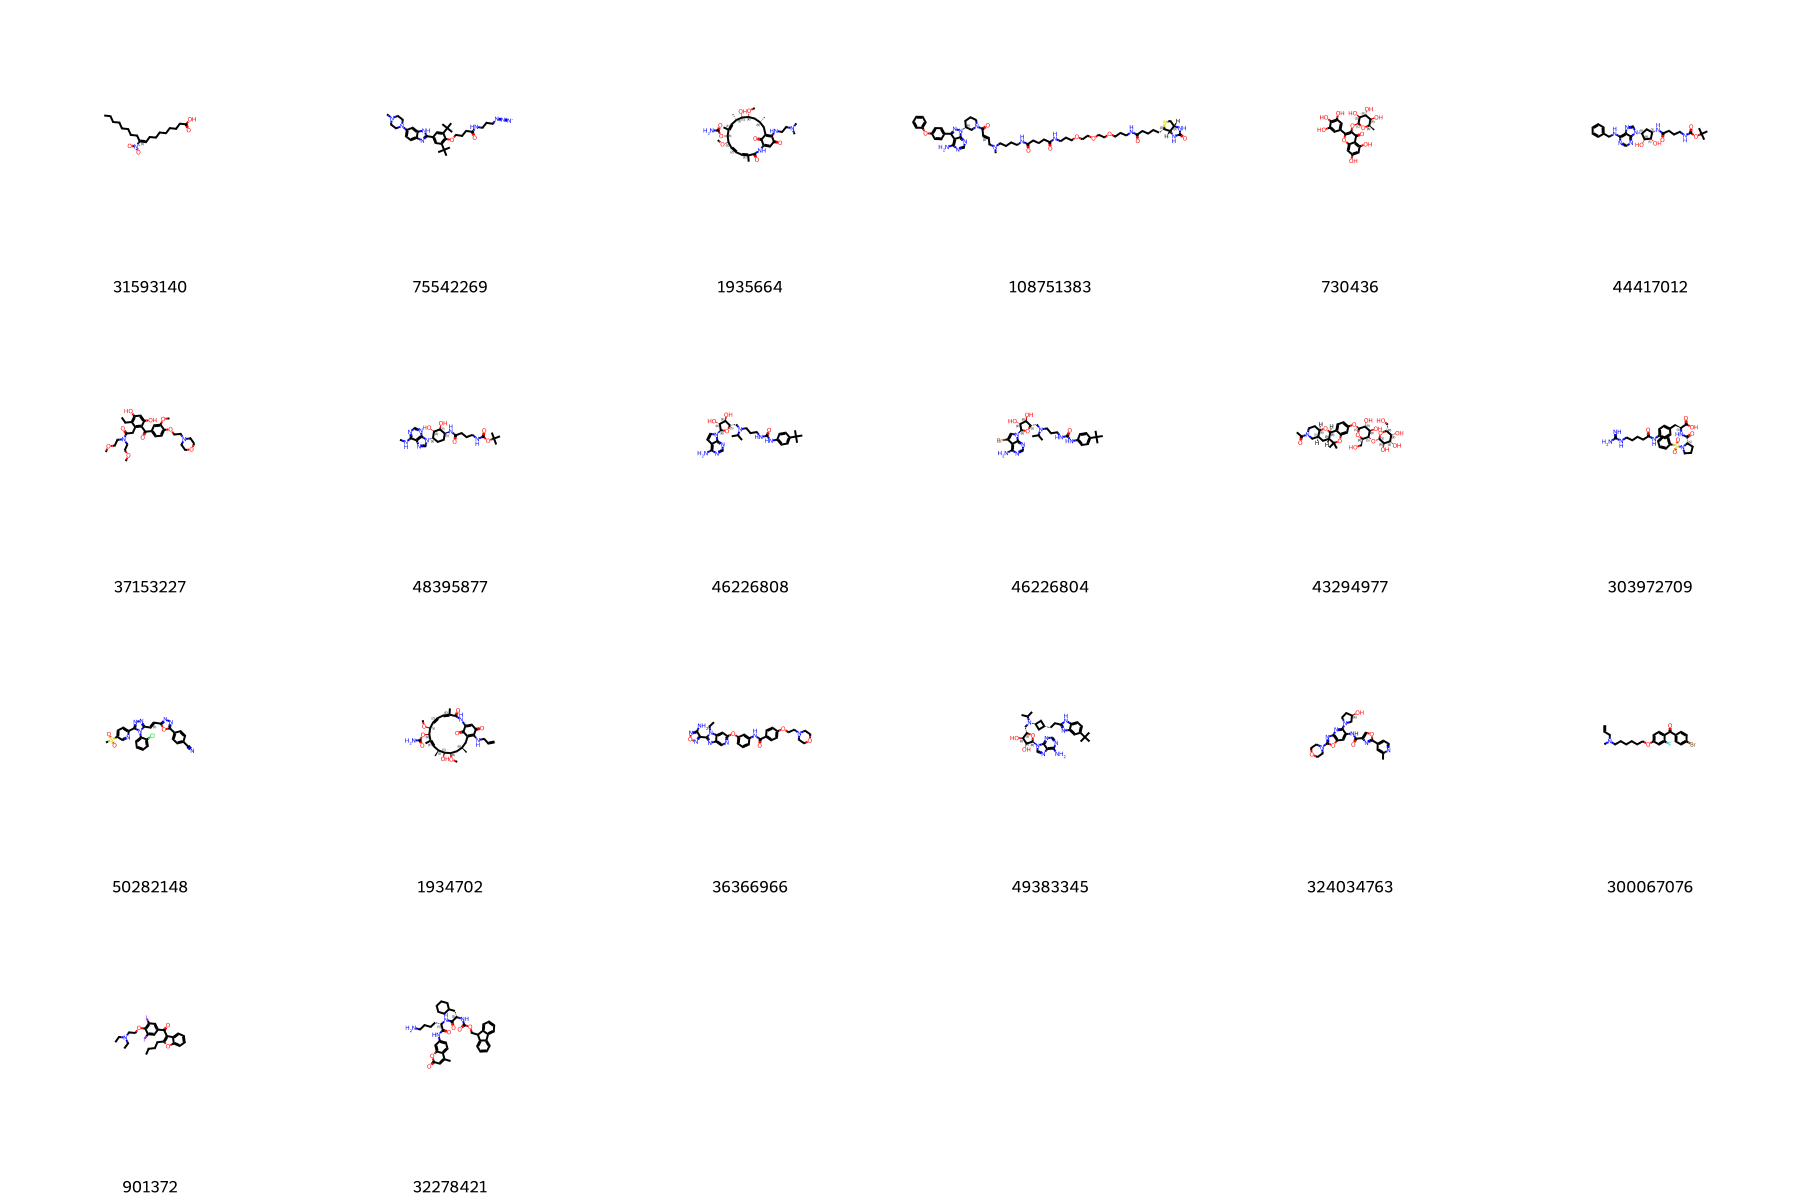

In [13]:
# visualize molecules which don't pass any of the nibr filters.
id_col = "Vendor ID"
to_plot = processed_df[~processed_df.pass_any]
legends = to_plot[id_col].astype(str).tolist()
dm.to_image(
    to_plot["mol"].tolist(), legends=legends, legendFraction=0.1, use_svg=True, n_cols=6
)

Upon reviewing the data, it is evident that molecules 1935664, 1934702, 108751383, 730436, and 43294977 contain potential "unwanted" substructures.
The molecule 1934702, also known as Tanespimycin, and 1935664, known as Alvespimycin, both inhibit HSP90 and are part of the macrocyclic molecules class.
Additionally, molecule 108751383, which is identified as Ibrutinib-biotin, serves as a probe constructed of Ibrutinib, biotin, and a linker.
Molecules 730436 and 43294977 are noticeable for having an excessive number of hydroxyl groups.


Considering their substantial structural difference from the remaining compounds in the dataset, which mainly comprises small molecules, it would be appropriate to exclude the aforementioned molecules from the dataset.

In [14]:
data = data.query(
    f"`{id_col}` not in  ['1935664', '1934702', '108751383', '730436', '43294977'] "
).reset_index(drop=True)

## Chemical space

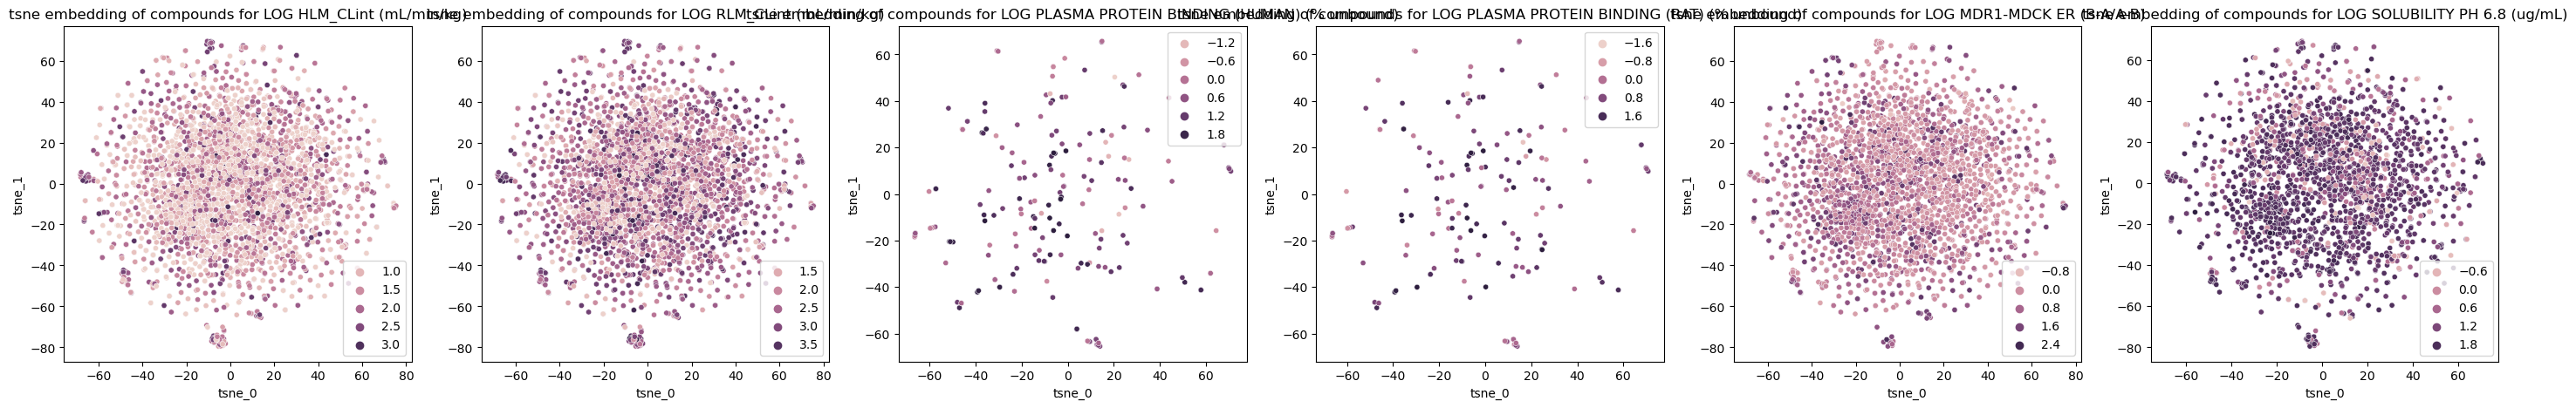

In [15]:
from utils import display_chemspace

fig = display_chemspace(df_full.copy(), mol_col="smiles", data_cols=data_cols)

## Perform data curation and export curated data

In [17]:
curator = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    mask_stereo_undefined_mols=True,
    keep_all_rows = False
)
df_curated = curator()

2023-11-08 12:11:11.295 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 3 outliers for data column LOG HLM_CLint (mL/min/kg) using zscore. Please revise the data and consider remove the outliers. 
2023-11-08 12:11:11.298 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 1 outliers for data column LOG PLASMA PROTEIN BINDING (RAT) (% unbound) using zscore. Please revise the data and consider remove the outliers. 
2023-11-08 12:11:11.299 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 1 outliers for data column LOG MDR1-MDCK ER (B-A/A-B) using zscore. Please revise the data and consider remove the outliers. 
2023-11-08 12:11:11.300 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 20 outliers for data column LOG SOLUBILITY PH 6.8 (ug/mL) using zscore. Please revise the data and consider remove the outliers. 


**Export curated data**

In [18]:
fout = "gs://polaris-public/data/ADME/fang2023_public_set_3521_curated.csv"
df_curated.reset_index(drop=True).to_csv(fout, index=False)